In [3]:
#pip install efficientnet

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

2025-09-03 11:46:52.977484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-03 11:46:53.249770: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-03 11:46:53.251809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-03 11:46:53.711200: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-03 11:46:55.961912: W tensorflow/com

In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [6]:
import efficientnet.tfkeras as efn
import efficientnet.tfkeras

In [7]:
# ---------------------------
# Dataset to numpy
# ---------------------------
def dataset_to_numpy(dataset):
    """Collect all images and labels from a tf.data.Dataset to NumPy arrays."""
    y_true_list = []
    y_pred_list = []

    for batch_images, batch_labels in dataset:
        # Handle label encoding
        if len(batch_labels.shape) > 1 and batch_labels.shape[-1] > 1:
            # one-hot -> convert to class indices
            true_idx = np.argmax(batch_labels.numpy(), axis=1)
        else:
            # integer labels
            true_idx = batch_labels.numpy().astype(int).reshape(-1)

        # Predict probabilities -> class indices
        #probs = model.predict(batch_images, verbose=0)
        probs = model.predict(batch_images)
        #print(probs)
        pred_idx = np.argmax(probs, axis=1)
        #print(true_idx)
        #print(pred_idx)

        y_true_list.append(true_idx)
        y_pred_list.append(pred_idx)

    y_true = np.concatenate(y_true_list, axis=0)
    y_pred = np.concatenate(y_pred_list, axis=0)
    return y_true, y_pred

In [8]:
# ---------------------------
# Compute confusion matrix
# ---------------------------
def plot_confusion_matrix(cm, class_names, normalize=True, title="Confusion Matrix"):
    """Plot confusion matrix with optional row normalization."""
    if normalize:
        cm = cm.astype(np.float64)
        row_sums = cm.sum(axis=1, keepdims=True)
        # avoid division by zero for any empty classes
        row_sums[row_sums == 0] = 1.0
        cm = cm / row_sums

    fig = plt.figure(figsize=(6.5, 6.5))
    plt.imshow(cm, interpolation="nearest", cmap="Blues") 
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0 if cm.size > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                verticalalignment="center",
                fontsize=9,
                color="white" if cm[i, j] > thresh else "black",
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

In [9]:
##Params
IMG_SIZE = (224, 224)
BATCH_SIZE = 220

In [10]:
#class_labels = ['Tomato___Bacterial_spot','Tomato___Early_blight','Tomato___Late_blight','Tomato___Septoria_leaf_spot','Tomato___healthy']
#class_names = class_labels

In [11]:
model = efn.EfficientNetB0(weights='imagenet')
model = load_model('../model/best_model.h5')

2025-09-03 11:47:05.236951: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [12]:
ds_path = '../data/all/tomato/'

In [13]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    ds_path,
    labels="inferred",
    label_mode="categorical",
    #class_names=class_labels,
    color_mode="rgb",
    shuffle=False,                    
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

Found 1679 files belonging to 5 classes.


In [14]:
class_names = test_ds.class_names
print("Classes:", class_names)

Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___healthy']


In [15]:
def normalize_like_single_image(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

In [16]:
test_ds = (
    test_ds
    .map(normalize_like_single_image)
)

In [17]:
y_true, y_pred = dataset_to_numpy(test_ds)

5/5 [==============================] - 4s 764ms/step


2025-09-03 11:48:36.009743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
## Run report
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
print("Confusion matrix (counts):\n", cm)

Confusion matrix (counts):
 [[424   0   0   1   0]
 [  1 197   2   0   0]
 [  1   8 373   0   0]
 [  0  10   0 343   1]
 [  0   0   0   0 318]]



Classification report:
                              precision    recall  f1-score   support

    Tomato___Bacterial_spot     0.9953    0.9976    0.9965       425
      Tomato___Early_blight     0.9163    0.9850    0.9494       200
       Tomato___Late_blight     0.9947    0.9764    0.9855       382
Tomato___Septoria_leaf_spot     0.9971    0.9689    0.9828       354
           Tomato___healthy     0.9969    1.0000    0.9984       318

                   accuracy                         0.9857      1679
                  macro avg     0.9800    0.9856    0.9825      1679
               weighted avg     0.9864    0.9857    0.9859      1679



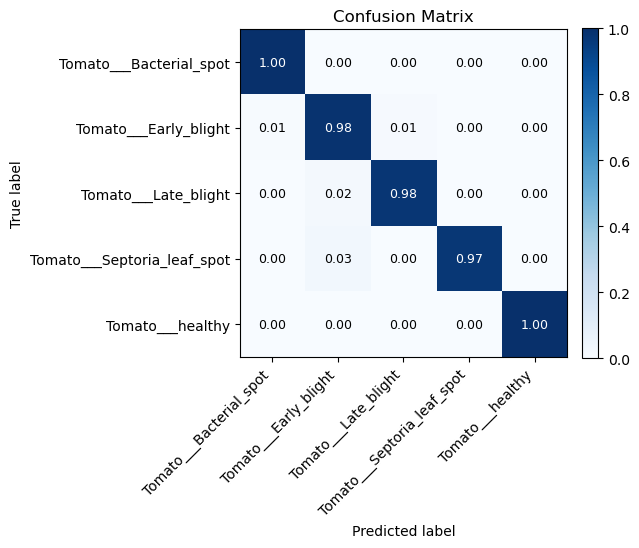

In [19]:
## Show report
# classification report
print("\nClassification report:\n",
      classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Plot normalized CM
plot_confusion_matrix(cm, class_names, normalize=True, title="Confusion Matrix")